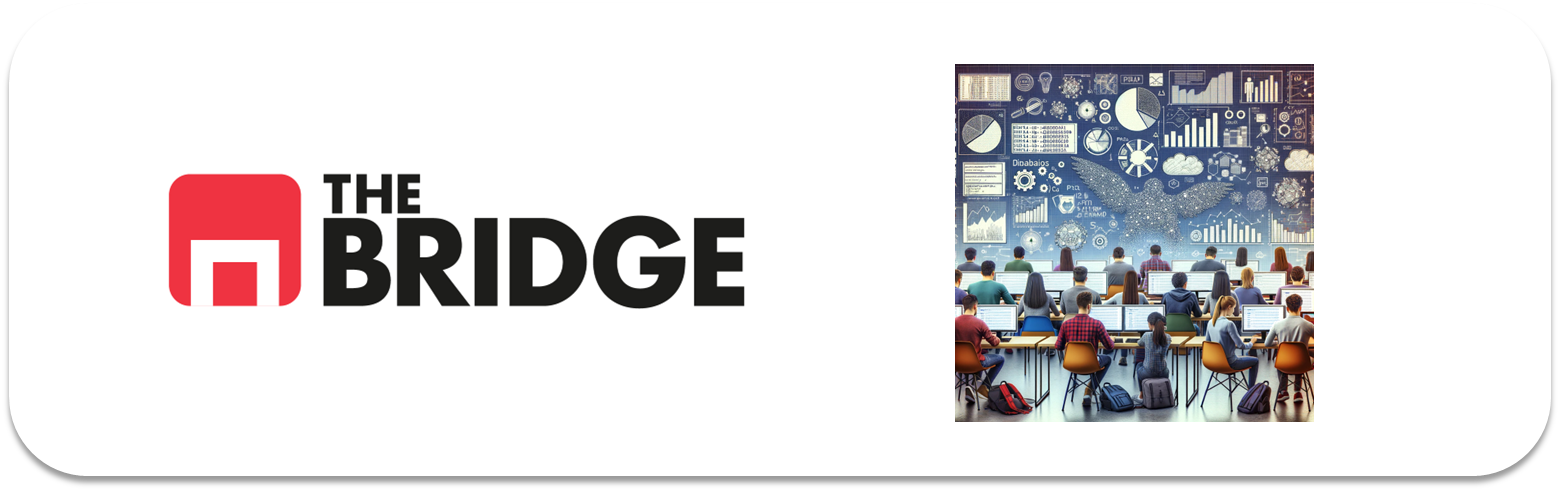

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
from bootcampviztools import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



In [3]:
df = pd.read_csv("./data/titanic.csv")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
target = "survived"
excluidas = ["embark_town","alive","class", "adult_male"]

<Axes: xlabel='survived', ylabel='count'>

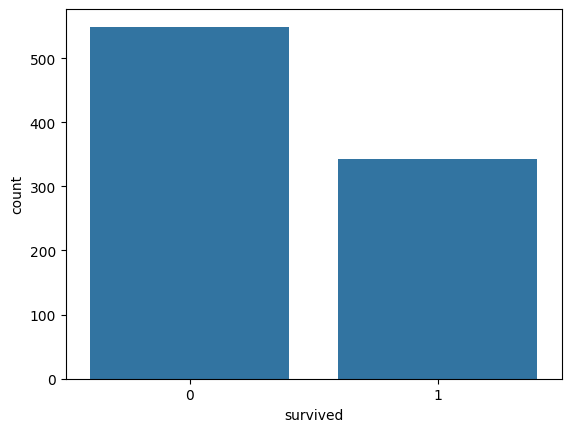

In [5]:
sns.countplot(data = df, x = 'survived')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [7]:
df.loc[df["embarked"].isna(), "embarked"] = "S"

- Separo por train y test

In [8]:
train_set, test_set = train_test_split(df, test_size = 0.2, stratify = df["embarked"], random_state = 42)

In [9]:
train_set.embarked.value_counts(normalize = True)

embarked
S    0.724719
C    0.188202
Q    0.087079
Name: proportion, dtype: float64

In [10]:
test_set.embarked.value_counts(normalize = True)

embarked
S    0.726257
C    0.189944
Q    0.083799
Name: proportion, dtype: float64

- Hay muchísima gente más embarcada en Southampton
- Train y Test tienen resultados muy parecidos

6. Imputamos

In [11]:
media_man = train_set[train_set.who == "man"]["age"].mean()
media_woman = train_set[train_set.who == "woman"]["age"].mean()
media_child = train_set[train_set.who == "child"]["age"].mean()

In [12]:
train_set.loc[(train_set.who == "man") & train_set.age.isna(), "age"] = media_man
train_set.loc[(train_set.who == "woman") & train_set.age.isna(), "age"] = media_woman
train_set.loc[(train_set.who == "child") & train_set.age.isna(), "age"] = media_child

In [13]:
test_set.loc[(test_set.who == "man") & test_set.age.isna(), "age"] = media_man
test_set.loc[(test_set.who == "woman") & test_set.age.isna(), "age"] = media_woman
test_set.loc[(test_set.who == "child") & test_set.age.isna(), "age"] = media_child

7. MINI-EDA

In [14]:
train_set[target].value_counts()

survived
0    446
1    266
Name: count, dtype: int64

In [15]:
features = ["age","sibsp","fare"]
features_categoricas = ["pclass","sex","embarked","alone","who"]

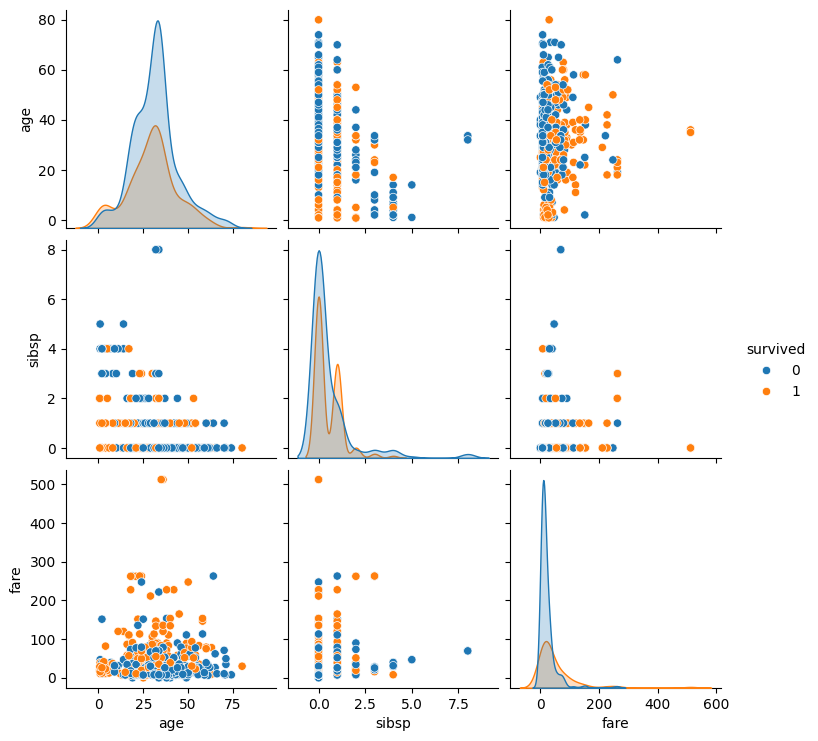

In [16]:
sns.pairplot(train_set[features + [target]], hue = target)

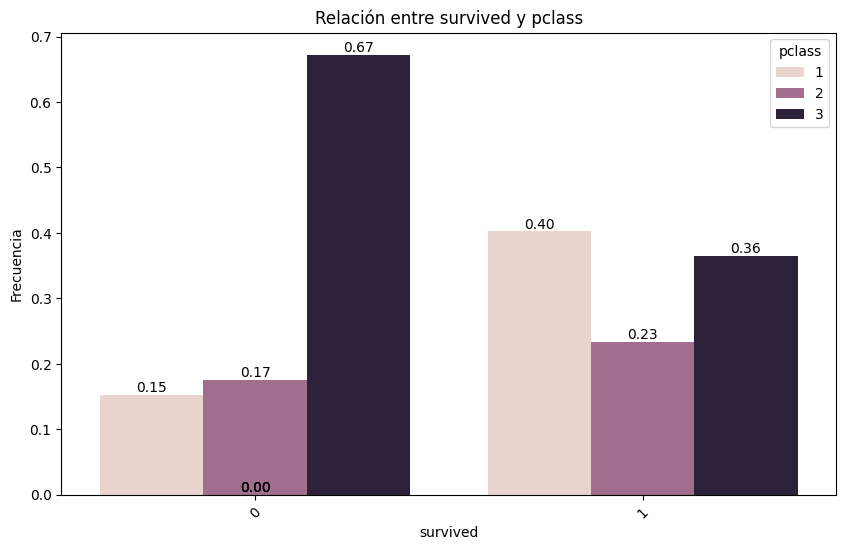

In [17]:
plot_categorical_relationship_fin(train_set, target, 'pclass', show_values = True, relative_freq = True)

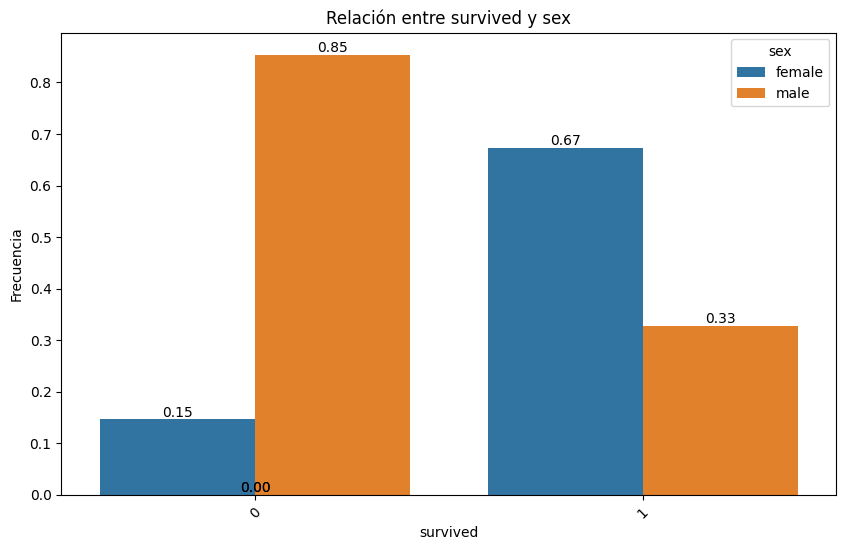

In [18]:
plot_categorical_relationship_fin(train_set, target, 'sex', show_values = True, relative_freq = True)

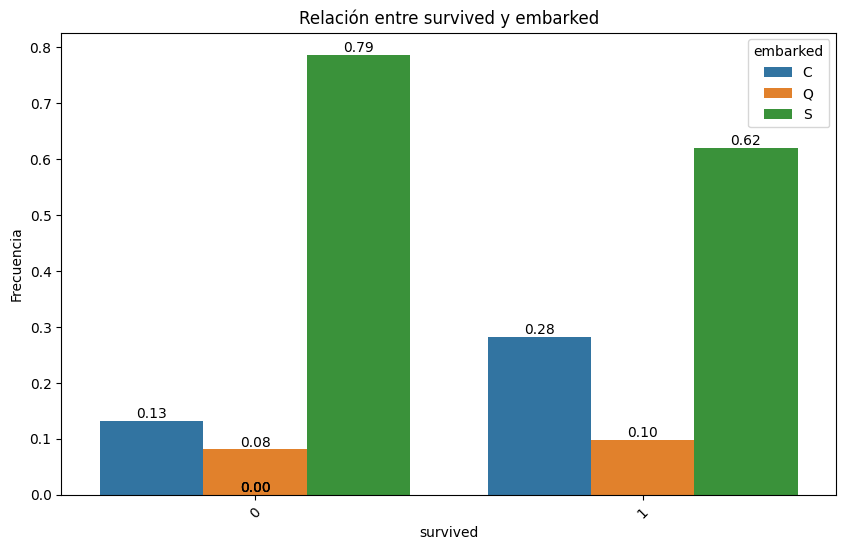

In [19]:
plot_categorical_relationship_fin(train_set, target, 'embarked', show_values = True, relative_freq = True)

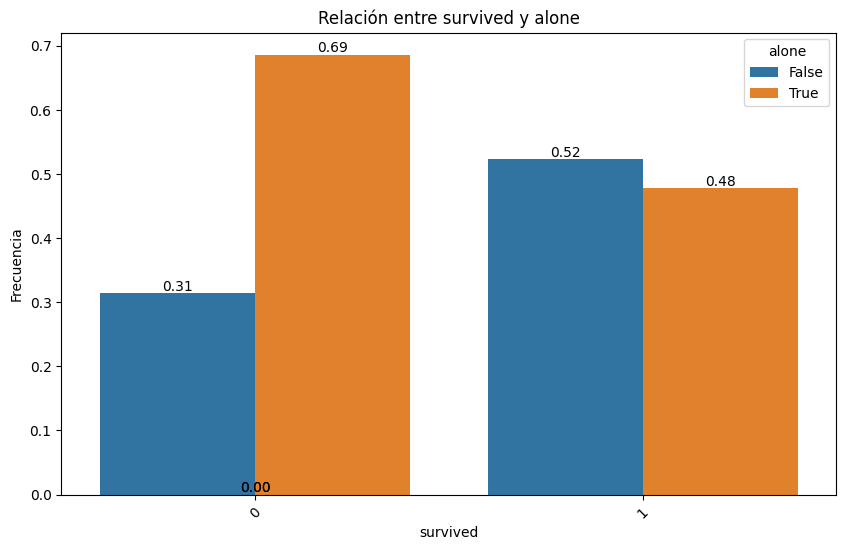

In [20]:
plot_categorical_relationship_fin(train_set, target, 'alone', show_values = True, relative_freq = True)

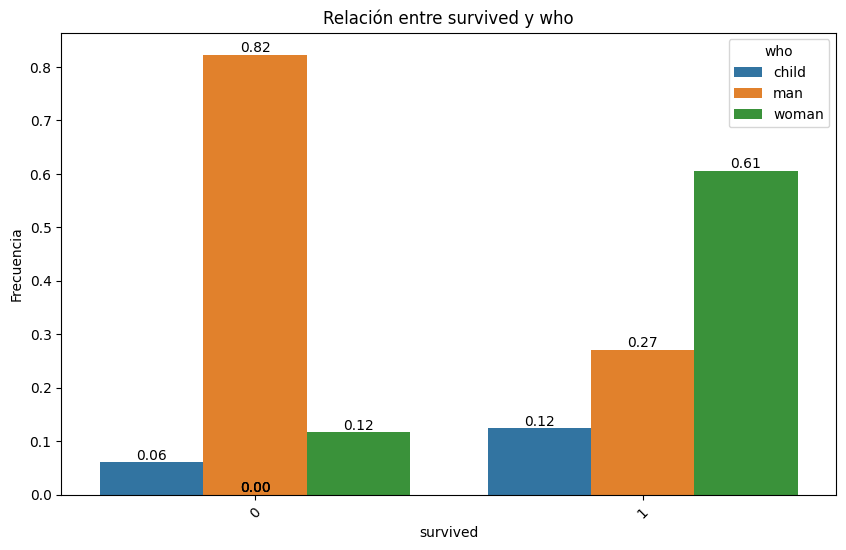

In [21]:
plot_categorical_relationship_fin(train_set, target, 'who', show_values = True, relative_freq = True)

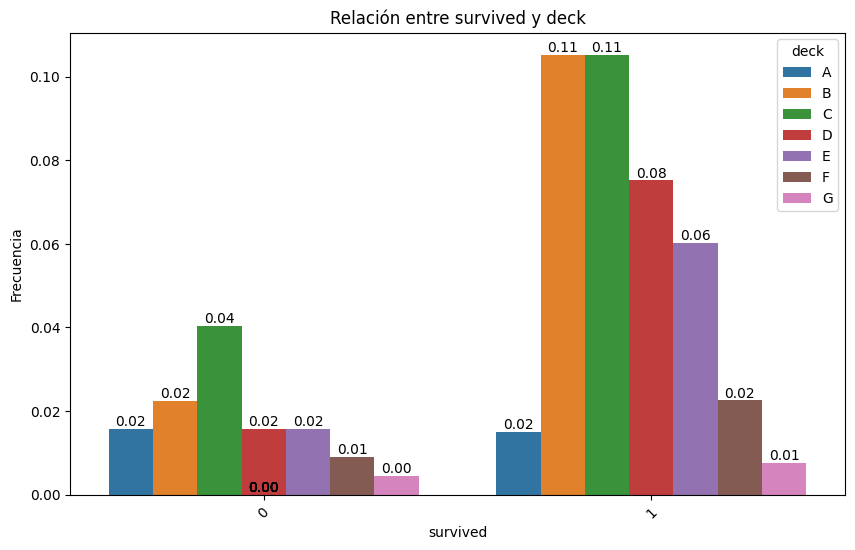

In [22]:
plot_categorical_relationship_fin(train_set, target, 'deck', show_values = True, relative_freq = True)

- Las features que voy a escoger son fare, age pclass, who, embarked, alone, porque se aprecia diferencias entre ellos

8. Trato las variables

- Proceso las categóricas

In [23]:
categories = [["male","female"],["S","C","Q"], ["man","woman","child"]]
encoder = OrdinalEncoder(categories = categories)

train_set[["sex","embarked","who"]] = encoder.fit_transform(train_set[["sex","embarked","who"]])
test_set[["sex","embarked","who"]] = encoder.transform(test_set[["sex","embarked","who"]])

- Proceso las numéricas

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'sibsp'}>],
       [<Axes: title={'center': 'fare'}>, <Axes: >]], dtype=object)

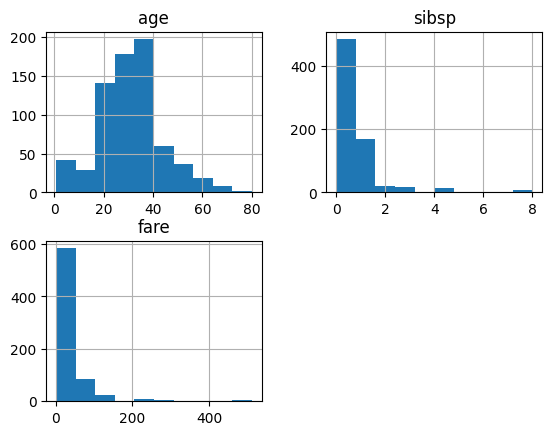

In [24]:
train_set[features].hist()

No puedo hacerle la conversión logarítmica a sibsp o fare porque tiene valores 0. Alternativas son hacer raíz cuadrada o cúbica

<Axes: >

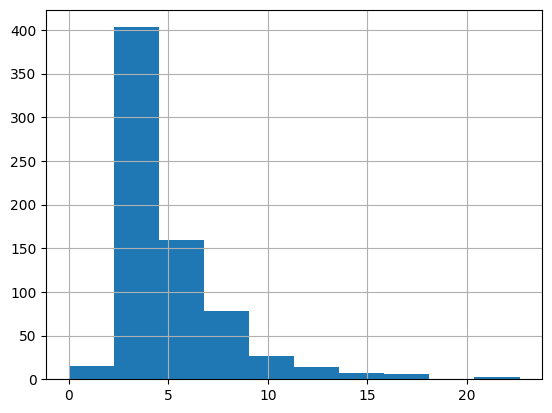

In [25]:
np.sqrt(train_set["fare"]).hist()

<Axes: >

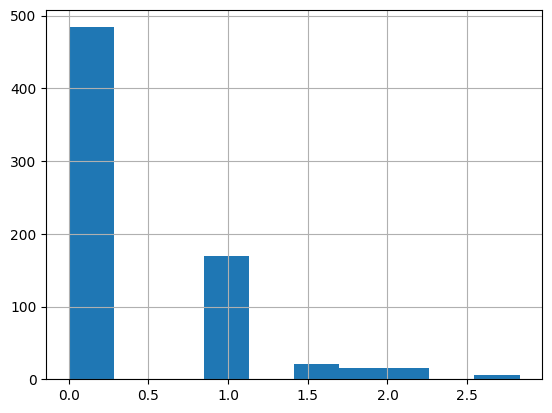

In [26]:
np.sqrt(train_set["sibsp"]).hist()

In [27]:
train_set["fare"] = np.sqrt(train_set["fare"])
test_set["fare"] = np.sqrt(test_set["fare"])
train_set["sibsp"] = np.sqrt(train_set["sibsp"])
test_set["sibsp"] = np.sqrt(test_set["sibsp"])

9. Modelo de regresión lineal

In [28]:
scaler = StandardScaler()

In [29]:
train_set[features] = scaler.fit_transform(train_set[features])
test_set[features] = scaler.transform(test_set[features])

In [30]:
train_set.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
838,1,3,0.0,0.090316,-0.633719,0,0.897981,0.0,Third,0.0,True,NaN,Southampton,yes,True
621,1,1,0.0,0.852154,1.001958,0,0.808591,0.0,First,0.0,True,D,Southampton,yes,False
282,0,3,0.0,-1.128624,-0.633719,0,-0.586889,0.0,Third,0.0,True,NaN,Southampton,no,True
275,1,1,1.0,2.452013,1.001958,0,1.337677,0.0,First,1.0,False,D,Southampton,yes,False
217,0,2,0.0,0.852154,1.001958,0,0.121009,0.0,Second,0.0,True,NaN,Southampton,no,False


In [31]:
features_categoricas_v2 = ['pclass', 'who', 'embarked']

In [32]:
X_train = train_set[features_categoricas_v2]
y_train = train_set[target]
X_test = test_set[features_categoricas_v2]
y_test = test_set[target]

In [33]:
clf = LogisticRegression(max_iter = 10000)

clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [35]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, clf.predict(X_train))
print(acc_train)

0.7935393258426966


In [36]:
from sklearn import model_selection
name='Logistic Regression'
cv_results = model_selection.cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')

msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(cv_results)
print(msg)

[0.74825175 0.77622378 0.83098592 0.81690141 0.8028169 ]
Logistic Regression: 0.795036 (0.029576)


In [37]:
y_proba = clf.predict_proba(X_train)
y_pred = clf.predict(X_train)

In [38]:
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), index=[f"Real {i}" for i in clf.classes_], 
                  columns=[f"Predicho {i}" for i in clf.classes_])

cm

,Predicho 0,Predicho 1
Real 0,385,61
Real 1,86,180


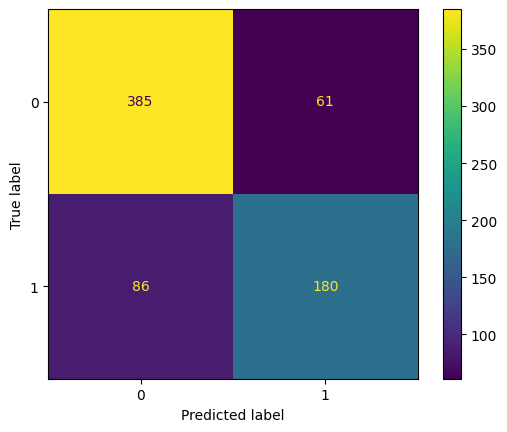

In [39]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred)

In [40]:
y_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

In [41]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=[f"Real {i}" for i in clf.classes_], 
                  columns=[f"Predicho {i}" for i in clf.classes_])

cm

,Predicho 0,Predicho 1
Real 0,87,16
Real 1,18,58


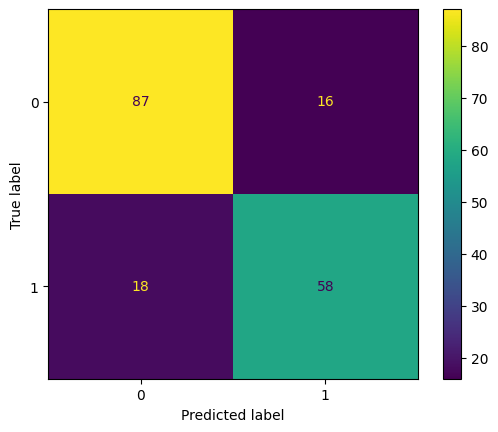

In [42]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [43]:
micro_prec = precision_score(y_test, y_pred, average="micro")
print("MICRO PRECISION:", micro_prec)

macro_prec = precision_score(y_test, y_pred, average="macro")
print("MACRO PRECISION:", macro_prec)

micro_rec = recall_score(y_test, y_pred, average="micro")
print("MICRO RECALL:", micro_rec)

macro_rec = recall_score(y_test, y_pred, average="macro")
print("MACRO RECALL:", macro_rec)

micro_acc = accuracy_score(y_test, y_pred)
print("MICRO ACCURACY:", micro_acc)

MICRO PRECISION: 0.8100558659217877
MACRO PRECISION: 0.8061776061776063
MICRO RECALL: 0.8100558659217877
MACRO RECALL: 0.8039090444557997
MICRO ACCURACY: 0.8100558659217877


In [44]:
acierto = accuracy_score(y_test, y_pred)

error = 1 - acierto
print("Acierto:", round(acierto*100, 2), "%")
print("Error:", round(error*100, 2), "%")

Acierto: 81.01 %
Error: 18.99 %


In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84       103
           1       0.78      0.76      0.77        76

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



- ROC curve

AUROC: 0.87


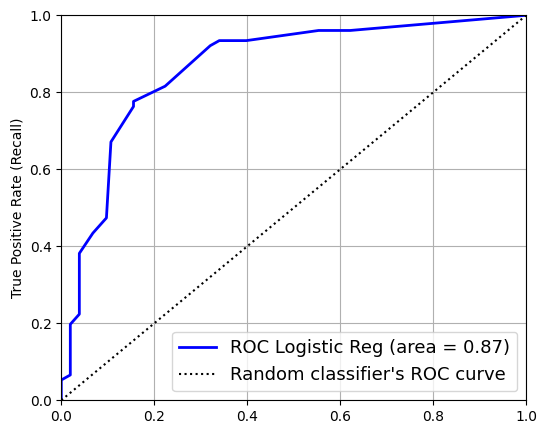

In [46]:
### Usando matplotlib
from sklearn.metrics import roc_curve, auc
scores = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, scores[:,1])
roc_auc = auc(fpr,tpr)
print("AUROC: %.2f" %(roc_auc))
plt.figure(figsize=(6, 5))  
plt.plot(fpr, tpr, linewidth=2, color= "blue", label=f"ROC Logistic Reg (area = {roc_auc:0.2f})")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)